# ADU Research Analysis

by Julia Ma

## Introduction 

Recently in California, the lack of affordable housing has risen exponentially. The cost of living has been very expensive, especially in heavily populated areas such as San Diego and Los Angeles. Howveer, a recent rising solution to this issue is the implementation and construction of __Accessory Dwelling Units (ADUs)__.

What are ADUs? Well, according to the [California Government](https://www.hcd.ca.gov/policy-and-research/accessory-dwelling-units), an Accessory Dwelling Unit is also known as an in-law unit, backyard cottage, secondary units, etc. They are smaller housing structure attached to the landlords home. The reason why they are good alternatives to solve the housing crisis is that they are more affordable housing, good source of income for homeowners, and help smaller families/single group occupants more. 

In this project, I will explore the construction of ADUs, specifically analyzing ADU permit data taken in LA 2023. Specifically, since higher permit costs equate to higher housing costs, I will explore the different ADU permit attributes to answer the following quesiton: __what factors are correlated with higher ADU permit costs?__ 



## Dataset Introduction

The dataset we will be using was obtained through the Construction Industry Research Board (CIRB) at the California Homebuilding Foundation. THe permits are all taken from Los Angeles County, and are all class Residential with U102 as their code from CIRB to indicate they are indeed ADU permits. The data provides information on 3387 ADU permits that were issued in Los Angeles, California for all of 2023.

In [502]:
# importing necessary packages to code 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [503]:
# contains ADU permit data for Los Angeles (LA) in 2023 only
ADU_df = pd.read_excel("/Users/juliama/Desktop/CIRB Data Entry/data science project/permit-breakdown-detailed (9).xlsx")
ADU_df.head()

,COUNTY*,CITY*,MONTH*,YEAR*,ISSUE DATE*,PERMIT NO,SOURCE*,CODE*,CLASS*,APN,...,ZIP,BUILDER,SQ FOOTAGE,UNITS,VALUATION*,NAME OF OWNER,PERMIT COST,NUMBER OF STORIES,PV CAPACITY,DESC
0,LOS ANGELES,AGOURA HILLS,JANUARY,2023.0,1/12/2023,RES-2021-0146,SECONDARY,U102,RESIDENTIAL,2055019048,...,91301,-,605.0,1.0,110000.0,-,0.0,0.0,-,Accessory Dwelling Unit
1,LOS ANGELES,AGOURA HILLS,JANUARY,2023.0,1/30/2023,RES-2022-0288,SECONDARY,U102,RESIDENTIAL,2055006015,...,91301,COLODNY HOLDINGS LLC,0.0,1.0,245000.0,-,0.0,0.0,-,Accessory Dwelling Unit
2,LOS ANGELES,AGOURA HILLS,FEBRUARY,2023.0,-,-,-,-,-,-,...,-,-,0.0,0.0,0.0,-,0.0,0.0,-,-
3,LOS ANGELES,AGOURA HILLS,MARCH,2023.0,-,-,-,-,-,-,...,-,-,0.0,0.0,0.0,-,0.0,0.0,-,-
4,LOS ANGELES,AGOURA HILLS,APRIL,2023.0,4/20/2023,RES-2022-0328,SECONDARY,U102,RESIDENTIAL,2055005030,...,91301,28336 DRIVER AVENUE LLC,936.0,1.0,150000.0,-,0.0,0.0,-,Accessory Dwelling Unit 1 Story


## Cleaning the Data

> identifying permit attributes to work with 

It seems like from the dataset, the following columns will be the most interesting to analyze how it correlates with `PERMIT COST`: `CITY*`,`ISSUE DATE*`,`SOURCE*`, `BUILDER`, `SQ FOOTAGE`, `UNITS`, `VALUATION*`, `NUMBER OF STORIES`, and `PV CAPACITY`

In [481]:
ADU_df[['CITY*', 'ISSUE DATE*', 'SOURCE*', 'BUILDER', 'SQ FOOTAGE', 'UNITS', 'VALUATION*', 'PERMIT COST', 'NUMBER OF STORIES', 'PV CAPACITY']].head()

,CITY*,ISSUE DATE*,SOURCE*,BUILDER,SQ FOOTAGE,UNITS,VALUATION*,PERMIT COST,NUMBER OF STORIES,PV CAPACITY
0,AGOURA HILLS,1/12/2023,SECONDARY,-,605.0,1.0,110000.0,0.0,0.0,-
1,AGOURA HILLS,1/30/2023,SECONDARY,COLODNY HOLDINGS LLC,0.0,1.0,245000.0,0.0,0.0,-
2,AGOURA HILLS,-,-,-,0.0,0.0,0.0,0.0,0.0,-
3,AGOURA HILLS,-,-,-,0.0,0.0,0.0,0.0,0.0,-
4,AGOURA HILLS,4/20/2023,SECONDARY,28336 DRIVER AVENUE LLC,936.0,1.0,150000.0,0.0,0.0,-


In [482]:
# replacing all "-" with NaNs, which means "Not a Number" or identifiable value. This makes the dataset easier to work with! 
ADU_df = ADU_df.replace("-", np.nan)
# removing the last 17 rows b/c they aren't relevant to the data analysis. The last 17 rows are just info to contact CIRB. 
last_17_rows = ADU_df.tail(17)
ADU_df.drop(last_17_rows.index, inplace = True)
# changing issue date to datettime type for easier mapping
def to_date(date):
    if date == "-":
        return np.nan 
    else: 
        return pd.to_datetime(date, format='%m/%d/%Y')

ADU_df['ISSUE DATE*'] = ADU_df['ISSUE DATE*'].apply(to_date)

# getting rid of 'PV CAPACITY' column b/c there are no values in there
ADU_df = ADU_df.drop(labels='PV CAPACITY', axis=1)

# here is the cleaned dataset!
ADU_df.head()

,COUNTY*,CITY*,MONTH*,YEAR*,ISSUE DATE*,PERMIT NO,SOURCE*,CODE*,CLASS*,APN,...,STATE,ZIP,BUILDER,SQ FOOTAGE,UNITS,VALUATION*,NAME OF OWNER,PERMIT COST,NUMBER OF STORIES,DESC
0,LOS ANGELES,AGOURA HILLS,JANUARY,2023.0,2023-01-12,RES-2021-0146,SECONDARY,U102,RESIDENTIAL,2055019048,...,CALIFORNIA,91301.0,NaN,605.0,1.0,110000.0,NaN,0.0,0.0,Accessory Dwelling Unit
1,LOS ANGELES,AGOURA HILLS,JANUARY,2023.0,2023-01-30,RES-2022-0288,SECONDARY,U102,RESIDENTIAL,2055006015,...,CALIFORNIA,91301.0,COLODNY HOLDINGS LLC,0.0,1.0,245000.0,NaN,0.0,0.0,Accessory Dwelling Unit
2,LOS ANGELES,AGOURA HILLS,FEBRUARY,2023.0,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN
3,LOS ANGELES,AGOURA HILLS,MARCH,2023.0,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN
4,LOS ANGELES,AGOURA HILLS,APRIL,2023.0,2023-04-20,RES-2022-0328,SECONDARY,U102,RESIDENTIAL,2055005030,...,CALIFORNIA,91301.0,28336 DRIVER AVENUE LLC,936.0,1.0,150000.0,NaN,0.0,0.0,Accessory Dwelling Unit 1 Story


## Exploring the Data

Now we will move on to identify patterns in the data through visualizations!

> Univariate plots 

The bar graph below shows how many ADU permits were issued per month, with the bars ordered from months with most to least issued permits. In other words, the graph implies that in LA 2023, the month with the most permits issued is __November__, followed by the month of August and October.

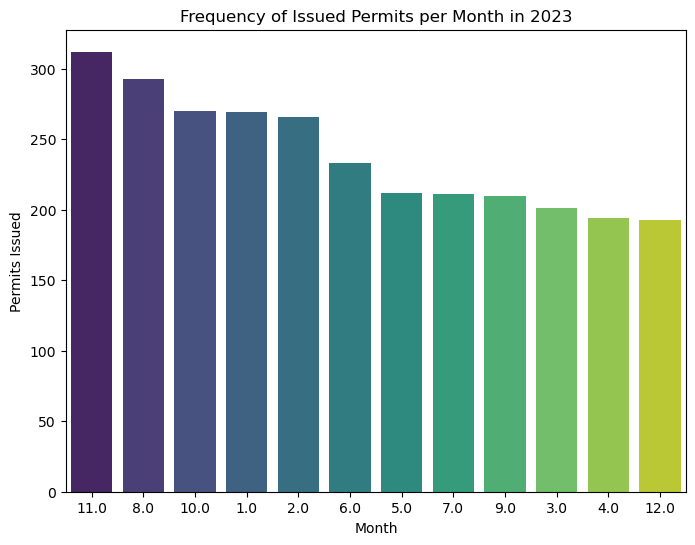

In [483]:
# months permits were issued in 
ADU_df['Issue Month'] = ADU_df['ISSUE DATE*'].dt.month

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Issue Month', data=ADU_df, order=ADU_df['Issue Month'].value_counts().index, palette='viridis')
plt.title('Frequency of Issued Permits per Month in 2023')
plt.xlabel('Month')
plt.ylabel('Permits Issued')
plt.show()

In [484]:
ADU_df.columns

Index(['COUNTY*', 'CITY*', 'MONTH*', 'YEAR*', 'ISSUE DATE*', 'PERMIT NO',
       'SOURCE*', 'CODE*', 'CLASS*', 'APN', 'ADDRESS', 'CITY', 'STATE', 'ZIP',
       'BUILDER', 'SQ FOOTAGE', 'UNITS', 'VALUATION*', 'NAME OF OWNER',
       'PERMIT COST', 'NUMBER OF STORIES', 'DESC', 'Issue Month'],
      dtype='object')

The graph below shows the valuations and permit costs throughout 2023 for each issued permit. As one can see, the permit costs are generally $0 and only increase in price when valuations also drastically increase in price as well. 

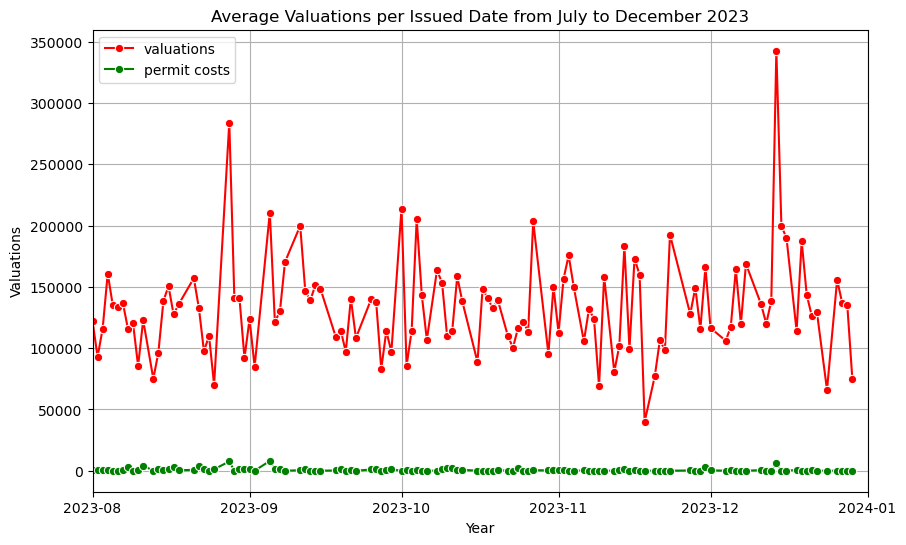

In [485]:
# averages quantitative numbers per issue date
avg_df = ADU_df[['ISSUE DATE*', 'SQ FOOTAGE', 'UNITS', 'VALUATION*', 'PERMIT COST']].groupby('ISSUE DATE*').mean()

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(x='ISSUE DATE*', y='VALUATION*', data=avg_df, marker='o', color='red', label = 'valuations')
sns.lineplot(x='ISSUE DATE*', y='PERMIT COST', data=avg_df, marker='o', color='green', label = 'permit costs')

# zoom functions
plt.xlim(pd.Timestamp('2023-08-01'), pd.Timestamp('2024-01-01'))
# plt.ylim(0, max(ADU_df['VALUATION*']))

plt.legend()
plt.title('Average Valuations per Issued Date from July to December 2023')
plt.xlabel('Year')
plt.ylabel('Valuations')
plt.legend()
plt.grid(True)
plt.show()

> bivariate plots



The scatterplot below shows the relationship between valuation and permit costs. There is a positive correlation between the two, that is, an increase in valuations increases the permit costs! 

_Note_: the lightly shaded red region around the regression line represents the confidence interval. The confidence interval tells us how confident we are the the true regression line lies. In other words, the bigger the shaded region, the higher the chance that our current linear regression line is inaccurate.  

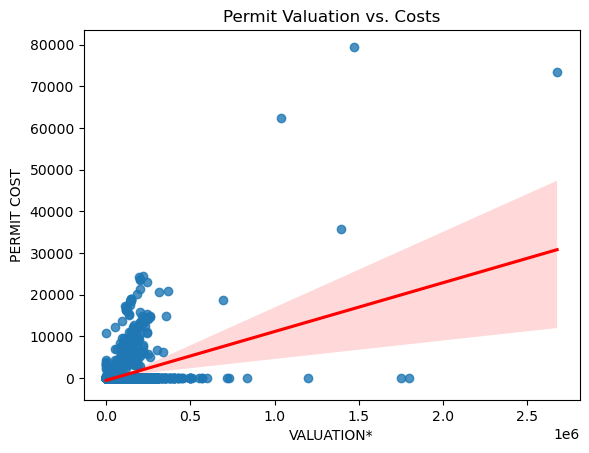

In [486]:
# permit valuation vs permit costs 

# with regression line
sns.regplot(data=ADU_df, x='VALUATION*', y='PERMIT COST', line_kws={'color': 'red'}, )

plt.title('Permit Valuation vs. Costs')
plt.show()

Text(0.5, 1.0, 'Top 3 Builders with the Most ADU Permits')

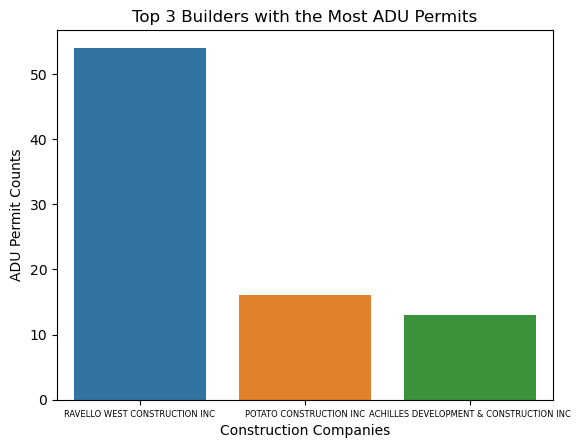

In [487]:
top_builders = ADU_df['BUILDER'].value_counts()
top_3_builders = top_builders.iloc[:3, ]
top_3_builders

sns.barplot(x=top_3_builders.index, y=top_3_builders)
plt.xticks(fontsize=6)

# Add labels and title
plt.xlabel('Construction Companies')
plt.ylabel('ADU Permit Counts')
plt.title('Top 3 Builders with the Most ADU Permits')


As you can see from the bar chart above, 
1. [Ravello West Construction Inc.](https://www.thebluebook.com/iProView/1692973/ravello-west-construction-inc/general-contractors/) has the most ADU permits, with a dominating 54 permits issued. 
2. [Potato Construction Inc.](https://www.potatoconstruction.com/) has the 2nd most ADU permits in LA at 16 permits
3. [Achilles Developement & Construction Inc.](https://www.linkedin.com/company/achillesus/about/) has 13 ADU permits. 

> number of stories vs. valuations 

In [488]:
ADU_df['NUMBER OF STORIES'].value_counts()

0.0    3334
1.0      30
2.0      23
Name: NUMBER OF STORIES, dtype: int64

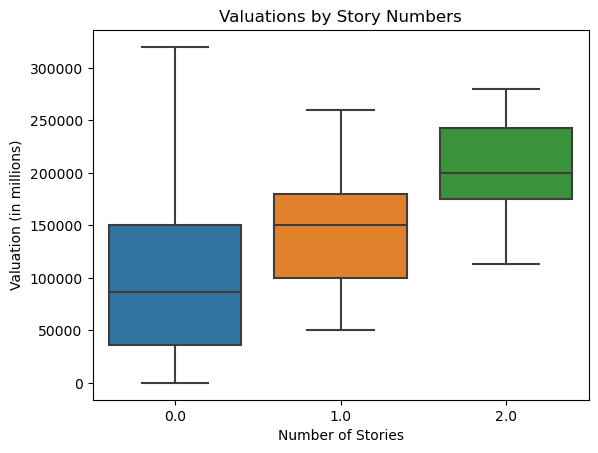

In [489]:
# no outliers
sns.boxplot(x='NUMBER OF STORIES', y='VALUATION*', data=ADU_df, showfliers=False)

# Add labels and title
plt.xlabel('Number of Stories')
plt.ylabel('Valuation (in millions)')
plt.title('Valuations by Story Numbers')

# Show plot
plt.show()

From the graph above displaying the relationship between the number of stories in a house and the permit valuation (without outliers), we can see that the more stories in the house, the higher the permit valuation is. However, houses with 0 stories have the most range and variations in valuations. 

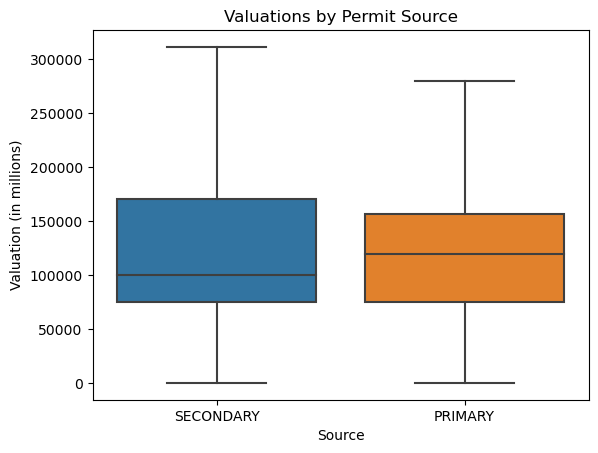

In [490]:
# no outliers
sns.boxplot(x='SOURCE*', y='VALUATION*', data=ADU_df, showfliers=False)

# Add labels and title
plt.xlabel('Source')
plt.ylabel('Valuation (in millions)')
plt.title('Valuations by Permit Source')

# Show plot
plt.show()

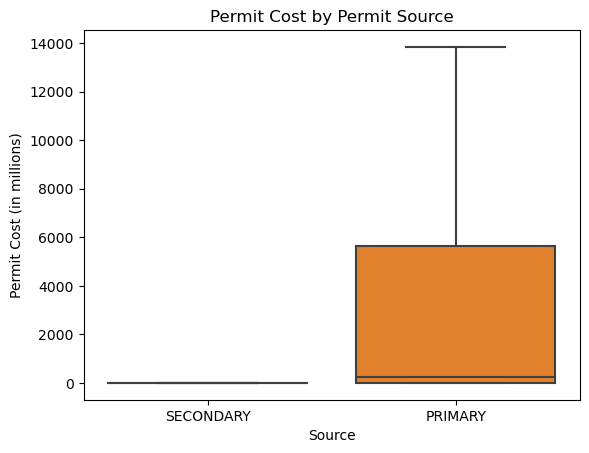

In [491]:
# no outliers
sns.boxplot(x='SOURCE*', y='PERMIT COST', data=ADU_df, showfliers=False)

# Add labels and title
plt.xlabel('Source')
plt.ylabel('Permit Cost (in millions)')
plt.title('Permit Cost by Permit Source')

# Show plot
plt.show()

# Hypothesis Testing

> First Question: Are higher valuations correlated with higher costs? 

Null hypothesis: Higher valuations are not correlated with higher costs.
Alternative Hypothesis: Higher valuations are correlated with higher costs.


In [492]:
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(ADU_df['VALUATION*'], ADU_df['PERMIT COST'])

# Print the correlation coefficient and p-value
print("Pearson correlation coefficient:", pearson_corr)
print("P-value:", p_value)

# Define significance level (e.g., 0.05)
alpha = 0.05

# Check if the correlation is statistically significant
if p_value < alpha:
    print("The correlation is statistically significant, so we reject the null hypotheiss")
else:
    print("The correlation is not statistically significant (fail to reject null hypothesis)")

Pearson correlation coefficient: 0.3976265490898388
P-value: 1.082393676032492e-128
The correlation is statistically significant, so we reject the null hypotheiss


Now we will do a permutation test to assess the significance

Observed correlation coefficient: 0.3976265490898388
Permutation test p-value: 0.0


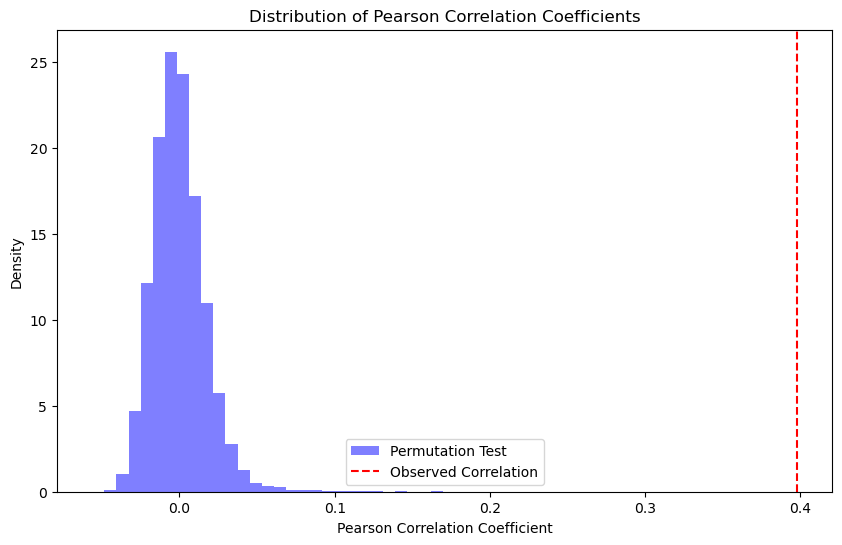

In [493]:
# Calculate the observed Pearson correlation coefficient
observed_corr, _ = pearsonr(ADU_df['VALUATION*'], ADU_df['PERMIT COST'])

# ------ permutation test
num_permutations = 10000
permuted_corrs = np.zeros(num_permutations) # Initialize an array to store permuted correlation coefficients

for i in range(num_permutations):
    permuted_costs = np.random.permutation(ADU_df['PERMIT COST'])
    permuted_corr, _ = pearsonr(ADU_df['VALUATION*'], permuted_costs)
    permuted_corrs[i] = permuted_corr

p_value_permutation = np.mean(np.abs(permuted_corrs) >= np.abs(observed_corr))
print("Observed correlation coefficient:", observed_corr)
print("Permutation test p-value:", p_value_permutation)

# ------- ploting the distribution of permuted correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(permuted_corrs, bins=30, density=True, alpha=0.5, color='blue', label='Permutation Test')

plt.axvline(x=observed_corr, color='red', linestyle='--', label='Observed Correlation')

plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Density')
plt.title('Distribution of Pearson Correlation Coefficients')
plt.legend()
plt.show()

The permutation test was run 10,000 times. The blue stack is the distribution and the red line is the observed value.

__Hypothesis Results/Conclusions__ 

The P-Value for this hypothesis test is of 0.000, which is less than our alpha of 0.05. This means that we can reject the null hypothesis. In other words, the valuation and permit costs are not uncorrelated. 

This could be explained by a mutlitude of factors and unknown variables, so we cannot draw any conclusion other that the variables are correlated.

## Geospatial Analysis (attempted)

using the longitude and latitute coordinates, we can plot a choropleth map to show which areas in LA had the most dense ADU parts.

> cleaning LA geo 

I want to just get the coordinates of each ADU permit, given in the `Latitude/Longitude` column.   

In [494]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
# will show graphs inside jupyternotebook
%matplotlib inline 

import plotly.express as px
import plotly.graph_objects as go 

#from mlp.toolkits.basemap import Basemap # for custom maps
from geopy.geocoders import Nominatim # turns addresses into coordinates
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable #for errors & exceptions

In [495]:
# # address replacement for geocoding
replacement_map = {'30601 JANLOR DR STE A': '30601 JANLOR DR', '5555 LEWIS LN STE A': '5555 LEWIS LN'}
ADU_df['ADDRESS'] = ADU_df['ADDRESS'].replace(replacement_map)


In [496]:
ADU_df[["ADDRESS", 'CITY', 'STATE', 'ZIP']].head()

,ADDRESS,CITY,STATE,ZIP
0,28445 FOOTHILL DR,AGOURA HILLS,CALIFORNIA,91301.0
1,5323 COLODNY DR,AGOURA HILLS,CALIFORNIA,91301.0
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,28336 DRIVER AVE,AGOURA HILLS,CALIFORNIA,91301.0


In [497]:
ADU_df['ZIP'].dtype

dtype('float64')

In [498]:
ADU_df['FULL ADDRESS'] = ADU_df['ADDRESS'] + ' ' + ADU_df['CITY'] + ' ' + ADU_df['STATE'] + ' ' + ADU_df['ZIP'].astype(str) 
ADU_df['FULL ADDRESS']

0       28445 FOOTHILL DR AGOURA HILLS CALIFORNIA 91301.0
1         5323 COLODNY DR AGOURA HILLS CALIFORNIA 91301.0
2                                                     NaN
3                                                     NaN
4        28336 DRIVER AVE AGOURA HILLS CALIFORNIA 91301.0
                              ...                        
3382            10247 SHERRILL ST WHITTIER CALIFORNIA nan
3383               12805 MCGEE DR WHITTIER CALIFORNIA nan
3384          7957 EUCLID AVE WHITTIER CALIFORNIA 90602.0
3385    8318 CALIFORNIA AVE A WHITTIER CALIFORNIA 90605.0
3386                                                  NaN
Name: FULL ADDRESS, Length: 3387, dtype: object

In [499]:
location = locator.geocode("- - - -")
location

In [500]:
# latitude_lst = []
# longitude_lst = []
# locator = Nominatim(user_agent="mygeocoder")

# def geocoded_address(address):
#     try: # to handle errors
#         location = locator.geocode(address)
#         if location is not None:
#             return location.latitude, location.longitude
#         else:
#             print(f"No location found for address: {address}")
#             return np.nan, np.nan
#     except GeocoderTimedOut as e:
#         print(f"Geocoding request timed out for address: {address}")
#         return np.nan, np.nan
#     except GeocoderUnavailable as e:
#         print(f"Geocoder service is unavailable for address: {address}")
#         return np.nan, np.nan
    
# for address in ADU_df['ADDRESS'].values:
#     latitude, longitude = geocoded_address(address)
#     latitude_lst.append(latitude)
#     longitude_lst.append(longitude)


In [501]:
# # first draft
# for address in ADU_df['ADDRESS'].values:
#     # if address is NaN
#     if pd.isna(address):
#         latitude_lst.append(np.nan)
#         longitude_lst.append(np.nan)
#     else:
#         new_address = address + ", LA"
#         location = locator.geocode(address)
#         if location is not None:
#             latitude_lst.append(location.latitude)
#             longitude_lst.append(location.longitude)
#         else:
#             print(f"Unable to geocode address: {address}")
#             latitude_lst.append(0)
#             longitude_lst.append(0)